In [10]:
import gymnasium as gym
import torch
from torch.autograd import Variable
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import deque
import copy

In [11]:
class DQN():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
        torch.nn.Linear(n_state, n_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(n_hidden, n_action)
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        self.model_target = copy.deepcopy(self.model)

    def update(self, s, y):
        # s: состояние
        # y: целевое значение
        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, s):
        #      s: входное состояние
        # return: значения Q для всех действий
        with torch.no_grad():
            return self.model(torch.Tensor(s))
        
    def target_predict(self, s):
        """
        Вычисляет значения Q-функции состояния для всех действий с помощью целевой сети
        @param s: входное состояние
        @return: целевые ценности состояния для всех действий
        """
        with torch.no_grad():
            return self.model_target(torch.Tensor(s))
        

    def copy_target(self):
        self.model_target.load_state_dict(self.model.state_dict())

    def replay(self, memory, replay_size, gamma):
        """
        Воспроизведение опыта
        @param memory: буфер воспроизведения опыта
        @param replay_size: сколько примеров использовать при каждом
        обновлении модели
        @param gamma: коэффициент обесценивания
        """
        if len(memory) >= replay_size:
            replay_data = random.sample(memory, replay_size)
            states = []
            td_targets = []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if is_done:
                    q_values[action] = reward
                else:
                    q_values_next = self.target_predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item()
                td_targets.append(q_values)
        
            self.update(states, td_targets)

In [12]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0, n_action - 1)
        else:
            q_values = estimator.predict(state)
        return torch.argmax(q_values).item()
    return policy_function

In [13]:
def q_learning(env, estimator, n_action, n_episode, total_reward_episode, memory, replay_size, target_update = 10, gamma=1.0, epsilon=0.1, epsilon_decay=.99):
    """
    Глубокое Q-обучение с применением DQN
    @param env: имя окружающей среды Gym
    @param estimator: объект класса Estimator
    @param n_episode: количество эпизодов
    @param gamma: коэффициент обесценивания
    @param epsilon: параметр ε-жадной стратегии
    @param epsilon_decay: коэффициент затухания epsilon
    """
    for episode in tqdm(range(n_episode)):

        if episode % target_update == 0:
            estimator.copy_target()

        policy = gen_epsilon_greedy_policy(estimator, epsilon, n_action)
        state = env.reset()[0]
        is_done = False
        is_break = False
        while not is_done and not is_break:
            action = policy(state)
            next_state, reward, is_done, is_break, _ = env.step(action)
            total_reward_episode[episode] += reward
            
            memory.append((state, action, next_state, reward, is_done))
            if is_done or is_break:
                break
            
            estimator.replay(memory, replay_size, gamma)
            state = next_state
        
        #print('Эпизод: {}, полное вознаграждение: {}, epsilon:{}'.format(episode,total_reward_episode[episode], epsilon))
        epsilon = max(epsilon * epsilon_decay, 0.01)

In [14]:
env = gym.envs.make("CartPole-v0")

n_state = env.observation_space.shape[0]
n_action = env.action_space.n

memory = deque(maxlen=10000)

n_episode = 600
last_episode = 200
replay_size = 20

n_hidden_options = [30, 40]
lr_options = [0.001, 0.003]
replay_size_options = [20, 25]
target_update_options = [30, 35]

for n_hidden in n_hidden_options:
    for lr in lr_options:
        for replay_size in replay_size_options:
            for target_update in target_update_options:
                file_name = '../agents/cart_pole_v0/dqn_double_{}_{}_{}_{}.pth'.format(n_hidden, lr, replay_size, target_update)

                env.reset(seed=1)
                random.seed(1)
                torch.manual_seed(1)
                dqn = DQN(n_state, n_action, n_hidden, lr)
                memory = deque(maxlen=10000)
                total_reward_episode = [0] * n_episode
                q_learning(env, dqn, n_action, n_episode, total_reward_episode, memory, replay_size, target_update, gamma=.9, epsilon=1)
                print(n_hidden, lr, replay_size, target_update, sum(total_reward_episode[-last_episode:])/last_episode)
                torch.save(dqn, file_name)



  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [04:20<00:00,  2.30it/s]


30 0.001 20 30 159.405


100%|██████████| 600/600 [04:31<00:00,  2.21it/s]


30 0.001 20 35 180.725


100%|██████████| 600/600 [04:42<00:00,  2.13it/s]


30 0.001 25 30 152.765


100%|██████████| 600/600 [05:59<00:00,  1.67it/s]


30 0.001 25 35 157.45


100%|██████████| 600/600 [04:50<00:00,  2.06it/s]


30 0.003 20 30 171.325


100%|██████████| 600/600 [04:24<00:00,  2.27it/s]


30 0.003 20 35 170.295


100%|██████████| 600/600 [04:27<00:00,  2.24it/s]


30 0.003 25 30 138.22


100%|██████████| 600/600 [04:13<00:00,  2.37it/s]


30 0.003 25 35 126.205


100%|██████████| 600/600 [04:44<00:00,  2.11it/s]


40 0.001 20 30 178.075


100%|██████████| 600/600 [03:25<00:00,  2.92it/s]


40 0.001 20 35 157.945


100%|██████████| 600/600 [04:39<00:00,  2.15it/s]


40 0.001 25 30 144.055


100%|██████████| 600/600 [05:58<00:00,  1.68it/s]


40 0.001 25 35 192.45


100%|██████████| 600/600 [04:28<00:00,  2.23it/s]


40 0.003 20 30 168.09


100%|██████████| 600/600 [04:11<00:00,  2.38it/s]


40 0.003 20 35 164.63


100%|██████████| 600/600 [05:53<00:00,  1.70it/s]


40 0.003 25 30 169.31


100%|██████████| 600/600 [05:07<00:00,  1.95it/s]

40 0.003 25 35 153.715


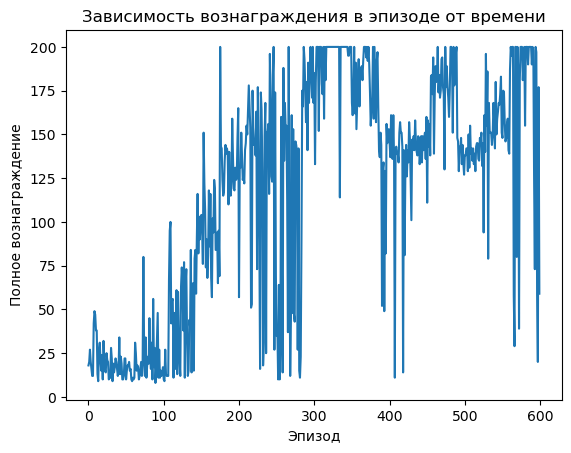

In [17]:
plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()

In [16]:
torch.save(dqn, '../agents/cart_pole_v0_ddqn.pth')